In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
from pathlib import Path
from typing import List, Tuple, Dict

# Wav Features and Visualization
import librosa
import IPython.display as ipd
# Basics
import numpy as np
import pandas as pd
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Machine Learning
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from catboost import CatBoostClassifier

# View Data

In [ ]:
def load_wav(path: str, sample_rate: int) -> np.ndarray:
    waveform, _ = librosa.load(path, sr=sample_rate)
    return waveform


def extract_features(
        file_path: str, 
        sample_rate: int=22050,
        hop_length: int=220,
        n_fft: int=2048,
        n_frames_per_example: int=1
    ) -> List[np.ndarray]:
    
    waveform = load_wav(file_path, sample_rate=sample_rate)
    
    spectrogram = librosa.feature.melspectrogram(
        waveform, n_fft=n_fft, hop_length=hop_length
    )
    
    spectrogram = np.log(1e-20 + np.abs(spectrogram ** 2))
    
    n_examples = spectrogram.shape[1] // n_frames_per_example
    
    return [
        spectrogram[
            :,
            i*n_frames_per_example:(i+1) * n_frames_per_example
        ].reshape(1, -1)
        for i in range(n_examples)
    ]

# Prepare Train Dataset

In [ ]:
def load_folder_data(
        path: Path, 
        train: bool, 
        params: Dict[str, int]
    ) -> Tuple[
        List[List[np.ndarray]], 
        List[str], 
        List[str]
    ]:
    
    features: List[List[np.ndarray]] = []
    labels: List[str] = []
    file_names: List[str] = list(path.rglob('*.wav'))

    for file_path in file_names:
        
        file_features = extract_features(file_path, **params)

        features.append(file_features)
        
        if train:
            class_name = file_path.parent.name
            labels.append([class_name] * len(file_features))
    
    return features, labels, file_names

In [ ]:
params = {
    'sample_rate': 22050,
    'hop_length': 220,
    'n_fft': 2048,
    'n_frames_per_example': 1
}

from google.colab import drive
drive.mount('/content/drive')

train_path = Path('/content/drive/MyDrive/Music Genre Recognition/train/train')
test_path = Path('/content/drive/MyDrive/Music Genre Recognition/test/test')
SEED = 42
test_size = 0.1

Mounted at /content/drive


In [ ]:
class_names = [folder.name for folder in train_path.iterdir()]

class_name2id = {
    class_name: class_id 
    for class_id, class_name in enumerate(class_names)
}

features, labels, file_names = load_folder_data(train_path, train=True, params=params)

labels = [
    [class_name2id[label] for label in label_list]
    for label_list in labels
]

In [ ]:
features_train, features_test, labels_train, labels_test, files_train, files_test = \
train_test_split(
    features, labels, file_names, test_size=test_size, random_state=SEED
)

In [ ]:
X_train = np.vstack([x for list_ in features_train for x in list_])
y_train = np.array([x for list_ in labels_train for x in list_])

In [ ]:
np.save("/content/drive/MyDrive/X_train", X_train)
np.save("/content/drive/MyDrive/y_train", y_train)

In [ ]:
# saving time
# X_train = np.load("/content/drive/MyDrive/X_train.npy")
# y_train = np.load("/content/drive/MyDrive/y_train.npy")

In [ ]:
catboost_1 = CatBoostClassifier(n_estimators=500, random_state=42, loss_function='MultiClass',
                             learning_rate=0.7, reg_lambda=100)

catboost_2 = CatBoostClassifier(n_estimators=300, random_state=24,
                             learning_rate=0.7, reg_lambda=70)

In [ ]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    # ('clf', VotingClassifier([('catboost_1', catboost_1), ('catboost_2', catboost_2)]))
    ('clf', catboost_1)
]).fit(X_train, y_train)

0:	learn: 1.9193589	total: 37.4s	remaining: 5h 10m 48s
1:	learn: 1.7891925	total: 1m 11s	remaining: 4h 58m 13s
2:	learn: 1.7111699	total: 1m 46s	remaining: 4h 53m 48s
3:	learn: 1.6632443	total: 2m 20s	remaining: 4h 51m 5s
4:	learn: 1.6260588	total: 2m 55s	remaining: 4h 49m 29s
5:	learn: 1.5916368	total: 3m 30s	remaining: 4h 48m 45s
6:	learn: 1.5677873	total: 4m 4s	remaining: 4h 47m 30s
7:	learn: 1.5464656	total: 4m 40s	remaining: 4h 47m 9s
8:	learn: 1.5273709	total: 5m 14s	remaining: 4h 46m 15s
9:	learn: 1.5099056	total: 5m 49s	remaining: 4h 45m 12s
10:	learn: 1.4944913	total: 6m 23s	remaining: 4h 44m 20s
11:	learn: 1.4756641	total: 6m 58s	remaining: 4h 43m 58s
12:	learn: 1.4616373	total: 7m 33s	remaining: 4h 43m 13s
13:	learn: 1.4459603	total: 8m 8s	remaining: 4h 42m 26s
14:	learn: 1.4306940	total: 8m 42s	remaining: 4h 41m 47s
15:	learn: 1.4240845	total: 9m 17s	remaining: 4h 40m 52s
16:	learn: 1.4115141	total: 9m 51s	remaining: 4h 40m 17s
17:	learn: 1.4012136	total: 10m 26s	remaining:

# Interpretation

In [ ]:
test_id = 890

predictions = pipe.predict_proba(np.vstack(features_train[test_id]))

plt.figure(figsize=(18,6))
plt.title(files_train[test_id])
wave_form = load_wav(files_train[test_id], sample_rate=params['sample_rate'])
time_axis = [x / params['sample_rate'] for x in range(wave_form.size)]
plt.plot(time_axis, wave_form)
plt.xlabel('seconds')
plt.show()

ipd.display(ipd.Audio(files_train[test_id]))
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title('Genre Probability by Frame')
sns.heatmap(
    predictions.T,
    yticklabels=class_names
)

plt.subplot(122)
plt.title('Averaged Probability')
plt.barh(class_names, predictions.mean(0))
plt.gca().invert_yaxis()
plt.show()

## Confusion matrix

In [ ]:
def plot_conf_matrix(y_test: np.ndarray, y_pred: np.ndarray, class_names: List[str], annot: bool=False) -> None:
    
    plt.figure(figsize=(8,6))
    plt.title(f"Accuracy: {(y_test == y_pred).mean():.2f}")
    sns.heatmap(
        confusion_matrix(y_test, y_pred), 
        xticklabels=class_names, 
        yticklabels=class_names,
        linewidths=.5,
        annot=annot
    )
    plt.show()

### by frame

In [ ]:
X_test = np.vstack([
    feature for feature_list in features_test 
    for feature in feature_list
])

y_test = np.array([label for label_list in labels_test for label in label_list])

y_pred = pipe.predict(X_test)

plot_conf_matrix(y_pred, y_test, class_names)

### by record

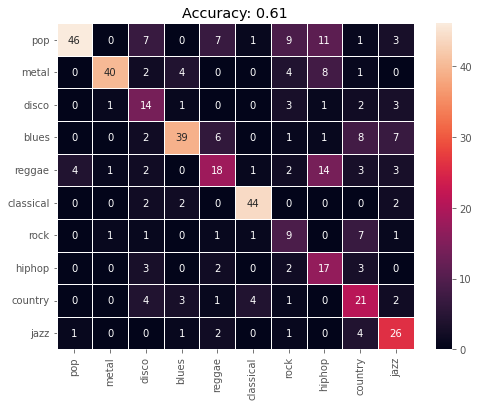

In [ ]:
y_pred = np.array([
    pipe.predict_proba(np.vstack(feature_list)).mean(0).argmax()
    for feature_list in features_test
])

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

# Test

In [ ]:
test_features, _, test_pathes = load_folder_data(test_path, train=False, params=params)

In [ ]:
predictions = [
    class_names[
        pipe.predict_proba(
            np.vstack(test_feature)
        ).mean(0).argmax()
    ]
    for test_feature in test_features
]

In [ ]:
(
    pd.DataFrame({
        'index': [test_wav_path.name for test_wav_path in test_path.iterdir()],
        'genre': predictions
    })
    .to_csv('submit.csv', index=False)
)